In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# with open('ranking_train.jsonl', 'r', encoding='utf-8') as f:
#     train_data = [json.loads(line) for line in f.readlines()]

# with open('ranking_test.jsonl', 'r', encoding='utf-8') as f:
#     test_data = [json.loads(line) for line in f.readlines()]
    
with open('ranking_train.jsonl', 'r') as f:
    train_data = list(f)

with open('ranking_test.jsonl', 'r') as f:
    test_data = list(f)


In [9]:
def parse_json_line(json_line):
    json_data = json.loads(json_line)
    text = json_data['text']
    comments = json_data['comments']
    comments_text = [comment['text'] for comment in comments]
    comments_score = [comment['score'] for comment in comments]
    return pd.DataFrame({'text': [text]*5, 'comment': comments_text, 'score': comments_score})

train_df = pd.concat([parse_json_line(line) for line in train_data], ignore_index=True)
test_df = pd.concat([parse_json_line(line) for line in test_data], ignore_index=True)


In [10]:
# Размер обучающей и тестовой выборок
print(f"Train samples: {len(train_df)}")
print(f"Test samples: {len(test_df)}")

# Общая информация по датафреймам
print(train_df.info())
print(test_df.info())

# Статистические характеристики данных
print(train_df.describe())


Train samples: 440535
Test samples: 70020
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440535 entries, 0 to 440534
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     440535 non-null  object
 1   comment  440535 non-null  object
 2   score    440535 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 10.1+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70020 entries, 0 to 70019
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     70020 non-null  object
 1   comment  70020 non-null  object
 2   score    0 non-null      object
dtypes: object(3)
memory usage: 1.6+ MB
None
               score
count  440535.000000
mean        2.000000
std         1.414215
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max         4.000000


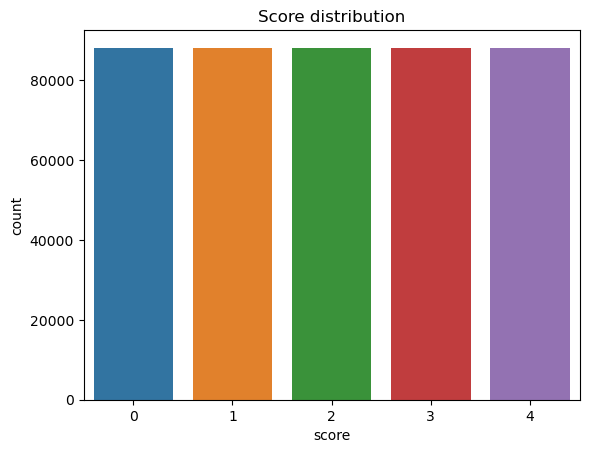

In [12]:
# Гистограмма распределения оценок комментариев
sns.countplot(x='score', data=train_df)
plt.title('Score distribution')
plt.show()


In [21]:
!pip install spacy
!pip install language_tool_python
!python -m spacy download en_core_web_sm

     ---------------------------------------- 12.8/12.8 MB 6.3 MB/s eta 0:00:00
[+] Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
import string
import spacy
import language_tool_python

nlp = spacy.load('en_core_web_sm')
tool = language_tool_python.LanguageTool('en-US')

def analyze_comments(df):
    # Инициализируем словарь для хранения результата
    result = {'numbers': [], 'links': [], 'hashtags': [], 'emojis': [], 'capslock': [], 'edit': [], 'non_english_words': [], 'punctuation_freq': [], 'errors': [], 'mentions': []}
    
    # Проходимся по всем комментариям
    for comment in df['comment']:
        # Поиск чисел
        numbers = re.findall(r'\d+', comment)
        result['numbers'].append(len(numbers))
        
        # Поиск ссылок
        links = re.findall(r'http\S+', comment)
        result['links'].append(len(links))
        
        # Поиск хэштегов
        hashtags = re.findall(r'#\w+', comment)
        result['hashtags'].append(len(hashtags))
        
        # Поиск смайлов
        emojis = re.findall(r'[^\w\s,]', comment)
        result['emojis'].append(len(emojis))
        
        # Поиск слов капслоком
        capslock = re.findall(r'\b[A-Z]{2,}\b', comment)
        result['capslock'].append(len(capslock))
        
        # Поиск количества Edit
        edit = comment.lower().count('edit')
        result['edit'].append(edit)
        
        # Поиск не английских слов
        non_english_words = sum([1 for word in comment.split() if not word.isascii()])
        result['non_english_words'].append(non_english_words)
        
        # Подсчет частоты использования пунктуации
        punct_freq = sum([1 for char in comment if char in string.punctuation]) / len(comment)
        result['punctuation_freq'].append(punct_freq)
        
        # Поиск ошибок в тексте
        # Установка библиотеки: pip install language-tool-python (требует java, установка что-то не идет, вроде как оракл заблокирвоала для рашки)
        errors = len(tool.check(comment))
        result['errors'].append(errors)
        
        # Поиск упоминаний других людей, мест и организаций
        # Установка библиотеки: pip install spacy
        doc = nlp(comment)
        entities = len(doc.ents)
        result['mentions'].append(entities)
    
    # Создаём датафрейм с результатом и возвращаем его
    return pd.DataFrame(result)

train_result = analyze_comments(train_df)
train_result

ModuleNotFoundError: No java install detected. Please install java to use language-tool-python.